# Denoising

## TESTING THE MARCENKO–PASTUR THEOREM

In this section, we test the Marcenko-Pastur Theorem, which is pivotal in statistical theory, especially for understanding the distribution of eigenvalues in large random covariance matrices derived from financial data. This theorem helps in distinguishing noise from significant eigenvalues.

### Generating Data and Initial Calculations

First, we generate a large matrix $X$ of random data and calculate its principal components to extract eigenvalues. Then, we apply both the theoretical Marcenko-Pastur probability density function (PDF) and a kernel density estimation (KDE) to the empirical data to compare theory with reality.

### Import libraries

In [27]:
import RiskLabAI.data.denoise.denoising as dn

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np

In [28]:
# Generate random data
x = np.random.normal(size=(10000, 1000))

# Compute eigenvalues using PCA on the correlation matrix
eval0, _ = dn.pca(np.corrcoef(x, rowvar=False))

# Theoretical Marcenko-Pastur PDF
pdf0 = dn.marcenko_pastur_pdf(1., q=x.shape[0] / float(x.shape[1]), num_points=1000)

# Fit KDE to the eigenvalues
pdf1 = dn.fit_kde(np.diag(eval0), bandwidth=.01)

### Setting up the Plot

Next, we set up the parameters for our plot, defining the eigenvalue range and creating a line space to plot our PDFs.

In [29]:
# Parameters for plot range based on variance and sample size ratio
var = 1
q = x.shape[0] / float(x.shape[1])
pts = 1000
emin, emax = var * (1 - (1. / q) ** .5) ** 2, var * (1 + (1. / q) ** .5) ** 2
_eval = np.linspace(emin, emax, pts)

### Plotting the Results

Before observing the plot, expect to see the alignment of the empirical eigenvalue distribution with the Marcenko-Pastur law, which signifies that most of the eigenvalues in a large random covariance matrix are bounded within specific limits dictated by this theorem.

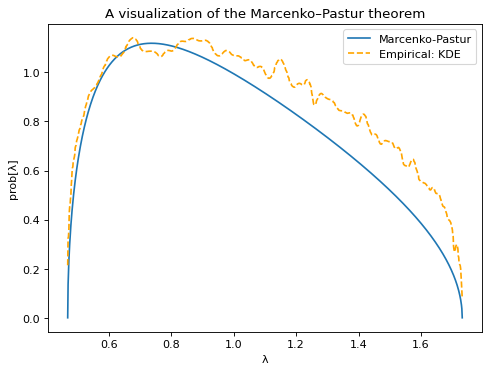

In [30]:
# Create and display the plot
plt.figure(figsize=(7, 5), dpi=80)
plt.plot(_eval, pdf0, label="Marcenko-Pastur")
plt.plot(_eval, pdf1, color='orange', ls='dashed', label="Empirical: KDE")
plt.title("A visualization of the Marcenko–Pastur theorem")
plt.xlabel("λ")
plt.ylabel("prob[λ]")
plt.legend(loc=0, frameon=True)
plt.show()

### Analysis of Results

The plot clearly illustrates that the empirical distribution (KDE) of eigenvalues closely follows the theoretical Marcenko-Pastur distribution. This alignment validates the underlying assumptions about the randomness and structure of the data matrix $X$. Notably, the presence of any eigenvalues outside this range might indicate potential signals or non-random structures worth investigating further.

## ADD SIGNAL TO A RANDOM COVARIANCE MATRIX

In this section, we enhance a random covariance matrix by injecting a structured signal into it. This helps us simulate more realistic scenarios where real-world data is often a mix of noise and informative signals. Understanding how signals affect the covariance matrix is crucial for techniques such as Principal Component Analysis (PCA).

### Creating the Mixed Covariance Matrix

Here, we start by generating a purely random covariance matrix and then introduce a signal. The parameter $\alpha$ controls the mix between the noise (original random covariance) and the signal (structured covariance), where a higher $\alpha$ value means more noise.

In [31]:
# Define parameters
alpha, ncols, nfact, q = .995, 1000, 100, 10  # High alpha to signify strong noise presence

# Generate a random covariance matrix
random_data = np.random.normal(size=(int(ncols * q), ncols))
cov = np.cov(random_data, rowvar=False)

# Introduce a signal into the covariance matrix
cov = alpha * cov + (1 - alpha) * dn.random_cov(ncols, nfact)  # noise + signal

# Convert the covariance matrix to a correlation matrix for normalization
corr0 = dn.cov_to_corr(cov)

# Perform PCA to find eigenvalues and eigenvectors
eval0, evec0 = dn.pca(corr0)

## FITTING THE MARCENKO–PASTUR PDF

In this part of the notebook, we fit the Marcenko-Pastur PDF to the empirical distribution of eigenvalues obtained from the enhanced covariance matrix. This fitting process helps identify the maximum eigenvalue that aligns with the theoretical Marcenko-Pastur distribution, allowing us to distinguish between noise and potential signal contributions in the dataset.

### Fitting the PDF and Identifying Maximum Eigenvalue

We utilize the eigenvalues from the previously enhanced covariance matrix to find the maximum eigenvalue that corresponds to the theoretical upper limit set by the Marcenko-Pastur law. This is crucial for understanding how much of the data's structure can be attributed to random noise.

In [32]:
# Find the maximum eigenvalue that fits within the Marcenko-Pastur distribution
emax0, var0 = dn.find_max_eval(np.diag(eval0), q, bandwidth=.01)

# Calculate the number of factors by counting eigenvalues above the Marcenko-Pastur threshold
nfacts0 = eval0.shape[0] - np.diag(eval0)[::-1].searchsorted(emax0)

The number of eigenvalues above this threshold, nfacts0, indicates the potential number of significant factors or signals present in the data.

In [33]:
nfacts0

100

Variance ($\sigma^2$) of the underlying process generating the observations, is var0.

In [34]:
var0

0.6771539068259487

## DENOISING 

### Constant residual eigenvalue method

In this section, we apply the Constant Residual Eigenvalue Method to denoise the correlation matrix obtained from our previous analysis. This method helps to refine the representation of the eigenvalues by reducing the noise components significantly, thereby allowing us to focus more clearly on the underlying signals.

#### Methodology

The denoising process involves adjusting the correlation matrix based on the number of factors (nfacts0) identified earlier as significant. This adjustment aims to isolate and remove the noise-influenced eigenvalues, enhancing the clarity and reliability of the data representation.

In [35]:
# Denoise the correlation matrix using the determined number of significant factors
corr1 = dn.denoised_corr(eval0, evec0, nfacts0)

# Perform PCA on the denoised correlation matrix to extract eigenvalues and eigenvectors
eval1, evec1 = dn.pca(corr1)

#### Plotting the Comparison

Before examining the plot, it's expected that the denoised eigenvalues will demonstrate a more compact spectrum, with reduced influence from the less significant components. This comparison provides a clear visualization of the effectiveness of the denoising process.

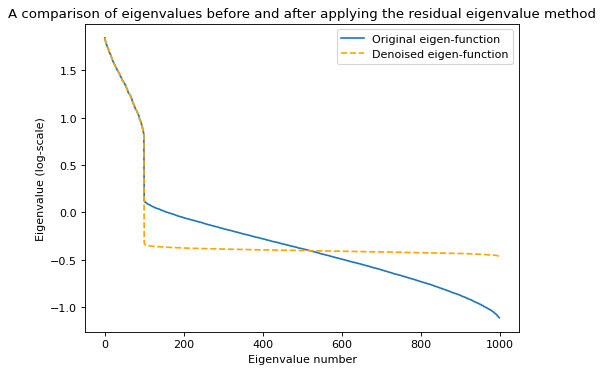

In [36]:
# Plotting original vs denoised eigenvalues on a logarithmic scale
plt.figure(figsize=(7, 5), dpi=80)
plt.plot(np.log(np.diag(eval0)), label='Original eigen-function')
plt.plot(np.log(np.diag(eval1)), color='orange', ls='dashed', label='Denoised eigen-function')
plt.title("A comparison of eigenvalues before and after applying the residual eigenvalue method")
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue (log-scale)")
plt.legend(loc=0, frameon=True)
plt.show()

#### Analysis of Results

The plot vividly illustrates how the denoising process streamlines the eigenvalue distribution. The denoised eigen-function shows fewer fluctuations and a more stable profile compared to the original, indicating that excess variability due to noise has been effectively minimized. This stabilization is crucial for downstream analyses, such as factor analysis or predictive modeling, where clarity in data representation significantly impacts performance and outcomes.

### Targeted Shrinkage

This section explores the use of the targeted shrinkage method to refine the correlation matrix derived from the PCA of our dataset. The targeted shrinkage approach adjusts eigenvalues based on a shrinkage parameter, $\alpha$, which helps balance between retaining the original data structure and reducing noise.

#### Methodology

The denoising is performed by modifying the correlation matrix using the identified number of significant factors (nfacts0). The $\alpha$ parameter controls the degree of shrinkage applied, with a value of 0.5 indicating a moderate balance between noise reduction and signal retention.

In [37]:
# Applying targeted shrinkage to denoise the correlation matrix
corr1 = dn.denoised_corr2(eval0, evec0, nfacts0, alpha=0.5)

# Perform PCA on the denoised correlation matrix to update eigenvalues and eigenvectors
eval1, _ = dn.pca(corr1)

#### Plotting the Comparison

The following plot compares the logarithm of the eigenvalues before and after the denoising process. The visualization aims to highlight the effect of the targeted shrinkage method on the eigenvalue spectrum.

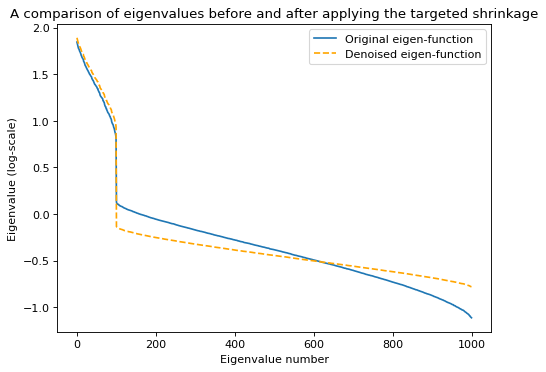

In [38]:
# Plot original vs denoised eigenvalues on a logarithmic scale
plt.figure(figsize=(7, 5), dpi=80)
plt.plot(np.log(np.diag(eval0)), label='Original eigen-function')
plt.plot(np.log(np.diag(eval1)), color='orange', ls='dashed', label='Denoised eigen-function')
plt.title("A comparison of eigenvalues before and after applying the targeted shrinkage")
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue (log-scale)")
plt.legend(loc=0, frameon=True)
plt.show()

#### Analysis of Results

This plot demonstrates the effectiveness of the targeted shrinkage method in reducing the variability of eigenvalues due to noise. The denoised eigen-function displays a more regular and typically lower variance across the spectrum compared to the original. This method proves particularly useful in scenarios where the preservation of some structural aspects of the original data is necessary while still aiming to minimize the influence of noise.

## GENERATING A BLOCK-DIAGONAL COVARIANCE MATRIX AND A VECTOR OF MEANS

This section focuses on generating a synthetic block-diagonal covariance matrix and a corresponding vector of means. Such structures are often used to model systems where different groups (or blocks) have high internal correlations but lower correlations with other groups. This is typical in financial data where sectors or industries exhibit group-specific characteristics.

### Methodology

We generate a covariance matrix with block-diagonal structure, where each block represents an economic sector with its specific correlation pattern. This type of synthetic data is useful for testing algorithms in a controlled environment, providing a clear understanding of how they might perform with real-world data.

In [39]:
# Set parameters for the block matrix
nblocks, bsize, bcorr = 10, 50, 0.5  # 10 blocks of size 50, with intra-block correlation of 0.5
np.random.seed(0)  # For reproducibility

# Generate the vector of means and the block-diagonal covariance matrix
mu0, cov0 = dn.form_true_matrix(nblocks, bsize, bcorr)

### Explanation of Parameters and Generation

* **nblocks**: Number of blocks in the covariance matrix, each corresponding to a different economic sector.
* **bsize**: Size of each block, indicating the number of variables within each sector.
* **bcorr**: The correlation coefficient within each block, set at 0.5, reflecting moderate internal similarity.

The variances within each block are uniformly distributed between 5% and 20%, providing a range of variability typical of financial asset returns. The vector of means is generated from a normal distribution, where the mean and standard deviation are matched to the standard deviation derived from the block variances.

## MINIMUM VARIANCE PORTFOLIO ESTIMATION ERRORS WITH AND WITHOUT DENOISING

This section delves into a Monte Carlo simulation to compare the performance of the minimum variance portfolio estimation when using denoised versus non-denoised empirical covariance matrices. The experiment leverages various advanced statistical treatments, including shrinkage and denoising, to understand their impact on portfolio optimization under different conditions.

### Experimental Setup

The Monte Carlo experiment involves:

1. Drawing a random empirical covariance matrix for each trial, with an option to apply Ledoit-Wolf shrinkage.
2. Optionally denoising the empirical covariance matrix using the constant residual eigenvalue method.
3. Deriving the minimum variance portfolio from the processed covariance matrix.

Parameters set for the experiment:

* **nObs**: Number of observations (T = 100).
* **ntrials**: Number of Monte Carlo trials (100).
* **bwidth**: Bandwidth for denoising.
* **shrink**: Boolean flag to indicate whether shrinkage is applied.
* **min_var_portf**: Boolean flag to indicate the calculation of a minimum variance portfolio.

### Methodology

The process incorporates drawing samples from a true covariance matrix, modifying them via shrinkage and denoising, and evaluating the performance of portfolio optimizations based on these modifications. This systematic approach allows us to critically assess the efficacy of denoising techniques in improving the robustness of financial portfolio optimizations.

In [43]:
# Setup experiment parameters
nObs, ntrials, bwidth, shrink, min_var_portf = 100, 100, 0.01, False, True

# Initialize DataFrame to store portfolio weights
w1 = pd.DataFrame(columns=range(cov0.shape[0]), index=range(ntrials), dtype=float)
w1_d = w1.copy(deep=True)  # DataFrame for denoised results

np.random.seed(0)  # For reproducibility

# Running the Monte Carlo experiment
for i in range(ntrials):
    # Simulate empirical covariance matrix
    mu1, cov1 = dn.simulates_cov_mu(mu0, cov0, nObs, shrink=shrink)

    # Optional step: nullify the mean for minimum variance portfolio
    if min_var_portf:
        mu1 = None
    
    # Denoise the covariance matrix if bWidth is specified
    cov1_d = dn.denoise_cov(cov1, nObs * 1. / cov1.shape[1], bwidth)
    
    # Calculate optimal portfolios
    w1.loc[i] = dn.optimal_portfolio(cov1, mu1).flatten()
    w1_d.loc[i] = dn.optimal_portfolio(cov1_d, mu1).flatten()

### Root-Mean-Square errors of portfolio weights

This concluding section quantitatively assesses the effectiveness of the denoising process applied to covariance matrices in portfolio optimization. We compute the Root-Mean-Square Error (RMSE) between the portfolio weights derived from the true (non-empirical) covariance matrix and those obtained from empirical matrices, both with and without denoising. RMSE provides a measure of the accuracy of portfolio weights, indicating the typical deviation from the true weights.

In [44]:
# Compute the optimal portfolio from the true covariance matrix
w0 = dn.optimal_portfolio(cov0, None if min_var_portf else mu0)

# Extend the true weights across all trials for comparison
w0 = np.repeat(w0.T, w1.shape[0], axis=0)

# Calculate RMSE for the original and denoised covariance matrices
rmsd = np.sqrt(np.mean((w1 - w0).values.flatten() ** 2))
rmsd_d = np.sqrt(np.mean((w1_d - w0).values.flatten() ** 2))

After computing the RMSE, we print the results to compare the error metrics:

In [45]:
print("RMSE for original empirical covariance matrix: ", rmsd)
print("RMSE for denoised empirical covariance matrix: ", rmsd_d)

RMSE for original empirical covariance matrix:  0.8193332229195457
RMSE for denoised empirical covariance matrix:  0.004742184928357209


These RMSE values quantify the average discrepancy between the weights of portfolios optimized with the true covariance matrix and those optimized with empirical matrices, assessing how much denoising improves portfolio weight estimation.


**Conclusion**

The results indicate the effectiveness of the denoising method in reducing errors in the estimated portfolio weights. A lower RMSE for the denoised matrices suggests that the denoising process helps align the empirical data more closely with the true underlying data structure, thereby enhancing the reliability of the resulting investment strategy. This analysis validates the use of denoising techniques in improving the accuracy of financial models, particularly in the context of portfolio optimization under uncertainty.